# Recognition of Gestures and Actions
- 사람의 Body Points(관절)을 감지하여 제스쳐와 동작을 구분하자

### 사용 데이터셋 MPII Human Pose Dataset : http://human-pose.mpi-inf.mpg.de/
- MPII Model: 인간의 움직임을 인식하도록 특별히 학습된 모듈 (유튜브 영상을 추출해서 학습했다.)
  - VGG 아키텍쳐(합성곱 신경망)를 사용하여 구성된다.
  - MPII와 이미지넷 데이터셋의 차이는 MPII는 사람의 포인트를 감지하고 이미지셋은 객체의 클래스를 분류하는것이다.
  - 추출 할 수 있는 인간의 body points 주로 사용하는건 0~15번까지이다. (원래는 더 있다.)
    - 0은 머리, 1은 목, 2는 오른쪽 어깨등 사람의 주요 관절을 감지하여 행동을 파악한다.

## Detecting Body Points

### Importing the libraries

In [3]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

### Loading the image
- Caaffe Deep Learning framework: https://caffe.berkeleyvision.org/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/megan.jpg')

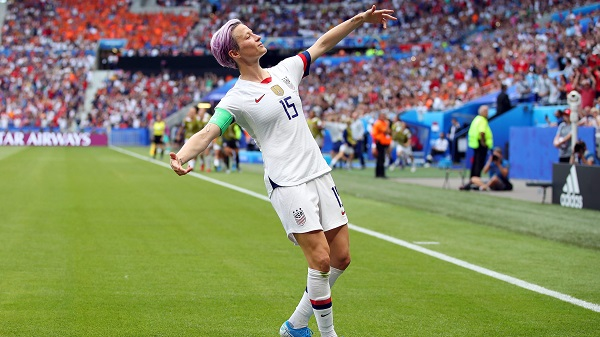

In [5]:
cv2_imshow(image)

In [7]:
# 이미지 shape, 전체 픽셀개수
image.shape, image.shape[0] * image.shape[1]* 3

((337, 600, 3), 606600)

### 이미지 모델에 전송하기(Blob)

 - 이미지를 모델에 전송하기위해 blob형식으로 바꿔야한다.
  - .blob: blob 형식은 바이너리 형식으로 큰 객체 ( 비디오, 이미지, 사운드 같은)를 저장하는 방식이다. 탄생 배경은 DB에서 정의되지 않은 형식의 데이터를 저장하기 위해 만들어진 형식이다. 기본적으로 용량이 큰 파일들은 여러 페이지(page,운영체제)로 나누어져서 저장되어지는것 보단 연결되어 관리되어지는게 편해서 blob을 사용하면 그것이 가능하다.
  - 딥러닝에선 이미지를 입력층으로 보낼때 주로 사용하는데 이진 데이터로 이미지의 픽셀 값, 크기, 채널 수를 관리하여 효율적으로 사용할수 있기때문이다.

In [10]:
type(image)

numpy.ndarray

In [8]:
# cv2.dnn.blobFromImage 이미지를 blob형식으로 변환
# 매개변수 : image- 이미지파일, scalefactor - 정규화 방식 , size=(너비,높이)
# Mean subtraction
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0/255,
                                   size = (image.shape[1],image.shape[0]))

In [9]:
# type은 같지만 shape이 이미지개수, 채널수, 높이, 너비로 바꼈다.
type(image_blob), image_blob.shape

(numpy.ndarray, (1, 3, 337, 600))